In [1]:
import warnings
warnings.filterwarnings('ignore')
# import required library
import sklearn
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd
import seaborn as sns
import shap
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from utils import scale_data, inverse_transform, lineplot, scatterplot

In [2]:
df = pd.read_excel('Data/all_data.xlsx')

In [3]:
df

,Date,Open,High,Low,Adj_Close,Volume,Sentimen,Index,Close
0,2023-03-01,23150.929688,23880.632813,23088.626953,23646.550781,24662841200,positif,43,23646.550781
1,2023-03-02,23647.019531,23739.138672,23245.021484,23475.466797,20386398516,negatif,45,23475.466797
2,2023-03-03,23476.632813,23479.347656,22213.238281,22362.679688,26062404610,negatif,52,22362.679688
3,2023-03-04,22362.923828,22405.177734,22198.980469,22353.349609,11166012913,negatif,40,22353.349609
4,2023-03-05,22354.144531,22613.685547,22307.142578,22435.513672,13317001733,negatif,38,22435.513672
...,...,...,...,...,...,...,...,...,...
361,2024-02-25,51565.214844,51950.027344,51306.171875,51733.238281,15413239245,positif,26,51733.238281
362,2024-02-26,51730.539063,54938.175781,50931.031250,54522.402344,34074411896,positif,39,54522.402344
363,2024-02-27,54519.363281,57537.839844,54484.199219,57085.371094,49756832031,positif,62,57085.371094
364,2024-02-28,57071.097656,63913.132813,56738.425781,62504.789063,83239156760,positif,100,62504.789063


# PREPROCESSING

In [4]:
df = df.drop(columns=['Date', 'Adj_Close'])

In [5]:
sentimen_mapping = {'positif': 1, 'negatif': -1, 'netral': 0}
df['Sentimen'] = df['Sentimen'].map(sentimen_mapping)

In [6]:
X = df.drop('Close', axis=1)
y = df['Close']

In [7]:
X, y, scaler = scale_data(df)

In [8]:
X

array([[[0.07002981, 0.08061168, 0.08466681, 0.24813463, 1.        ,
         0.2962963 ]],

       [[0.08175457, 0.07736212, 0.0884934 , 0.19324368, 0.        ,
         0.32098765]],

       [[0.07772759, 0.07139575, 0.06324821, 0.26609894, 0.        ,
         0.40740741]],

       ...,

       [[0.74549014, 0.79388071, 0.76590194, 0.3689383 , 1.        ,
         0.24691358]],

       [[0.81140218, 0.85358472, 0.85283922, 0.57023243, 1.        ,
         0.5308642 ]],

       [[0.87171075, 1.        , 0.9079946 , 1.        , 1.        ,
         1.        ]]])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# MODELING

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def declare_model(n_lstm, neuron, epoch, X_train, y_train, X_test, y_test):
    model = Sequential()    
    try:
        if n_lstm == 1:
            model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        elif n_lstm == 2:
            model.add(LSTM(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
            model.add(LSTM(units=neuron))
        else:
            print("Invalid LSTM configuration")

        model.add(Dense(25))
        model.add(Dense(1))

        model.compile(optimizer='adam', loss='mean_squared_error')

        history = model.fit(X_train, y_train, batch_size=32, epochs=epoch, validation_data=(X_test, y_test))

        return history 
    except Exception as e:
        print(f"Error during model training: {e}")
        return None 

def tune_model_parameters(X_train, y_train, X_test, y_test, lstm_configs):
    results = {} 

    for n_lstm in lstm_configs['n_lstm']:
        for neuron in lstm_configs['neurons']:
            for epoch in lstm_configs['epochs']:
                print(f'Running trial with n_lstm={n_lstm}, neuron={neuron}, epoch={epoch}')
                key = f'n_lstm={n_lstm}_neurons={neuron}_epochs={epoch}'
                history = declare_model(n_lstm, neuron, epoch, X_train, y_train, X_test, y_test)
                
                if history is not None:
                    mse_train = history.history['loss'][-1]  
                    mse_test = history.history['val_loss'][-1] 
                    results[key] = {'history': history.history, 'mse_train': mse_train, 'mse_test': mse_test}
                else:
                    print(f"Skipping combination n_lstm={n_lstm}, neuron={neuron}, epoch={epoch} due to error")

    return results

lstm_configs = {
    'n_lstm': [1, 2], 
    'neurons': [50, 100, 150, 200],  
    'epochs': [10, 20, 30] 
}

In [11]:
results = tune_model_parameters(X_train, y_train, X_test, y_test, lstm_configs)

Running trial with n_lstm=1, neuron=50, epoch=10
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0285 - val_loss: 0.0590
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0180 - val_loss: 0.1069
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0150 - val_loss: 0.1291
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0124 - val_loss: 0.1008
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0135 - val_loss: 0.1212
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111 - val_loss: 0.1253
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0128 - val_loss: 0.1262
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0127 - val_loss: 0.1285
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0132 - val_loss: 0.1280
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0122 - val_loss: 0.1392
Running trial with n_lstm=1, neuron=50, epoch=20
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0

In [12]:
hasil = []

for key, value in results.items():
    mse_train = value['mse_train']
    mse_test = value['mse_test']
    hasil.append({
        'experiment': key,
        'mse_train': mse_train,
        'mse_test': mse_test
    })

hp_lstm = pd.DataFrame(hasil)

for result in hasil:
    print(f"Experiment: {result['experiment']}, MSE Train: {result['mse_train']}, MSE Test: {result['mse_test']}")

Experiment: n_lstm=1_neurons=50_epochs=10, MSE Train: 0.012572575360536575, MSE Test: 0.139193594455719
Experiment: n_lstm=1_neurons=50_epochs=20, MSE Train: 0.012429039925336838, MSE Test: 0.14409121870994568
Experiment: n_lstm=1_neurons=50_epochs=30, MSE Train: 0.012388262897729874, MSE Test: 0.14281535148620605
Experiment: n_lstm=1_neurons=100_epochs=10, MSE Train: 0.012473701499402523, MSE Test: 0.136355459690094
Experiment: n_lstm=1_neurons=100_epochs=20, MSE Train: 0.01248365268111229, MSE Test: 0.14248569309711456
Experiment: n_lstm=1_neurons=100_epochs=30, MSE Train: 0.012531979940831661, MSE Test: 0.14787039160728455
Experiment: n_lstm=1_neurons=150_epochs=10, MSE Train: 0.012620922178030014, MSE Test: 0.12915846705436707
Experiment: n_lstm=1_neurons=150_epochs=20, MSE Train: 0.012416042387485504, MSE Test: 0.14454542100429535
Experiment: n_lstm=1_neurons=150_epochs=30, MSE Train: 0.012494551949203014, MSE Test: 0.13494645059108734
Experiment: n_lstm=1_neurons=200_epochs=10, M

In [13]:
hp_lstm

,experiment,mse_train,mse_test
0,n_lstm=1_neurons=50_epochs=10,0.012573,0.139194
1,n_lstm=1_neurons=50_epochs=20,0.012429,0.144091
2,n_lstm=1_neurons=50_epochs=30,0.012388,0.142815
3,n_lstm=1_neurons=100_epochs=10,0.012474,0.136355
4,n_lstm=1_neurons=100_epochs=20,0.012484,0.142486
5,n_lstm=1_neurons=100_epochs=30,0.012532,0.147870
6,n_lstm=1_neurons=150_epochs=10,0.012621,0.129158
7,n_lstm=1_neurons=150_epochs=20,0.012416,0.144545
8,n_lstm=1_neurons=150_epochs=30,0.012495,0.134946
9,n_lstm=1_neurons=200_epochs=10,0.012699,0.125056


In [14]:
hp_lstm.to_excel("kombinasi-parameter.xlsx")

In [15]:
max_mse_train_index = hp_lstm['mse_train'].idxmin()
max_mse_train_row = hp_lstm.loc[max_mse_train_index]
print(max_mse_train_row)

experiment    n_lstm=2_neurons=100_epochs=30
mse_train                           0.000317
mse_test                            0.001249
Name: 17, dtype: object


In [16]:
max_mse_test_index = hp_lstm['mse_test'].idxmin()
max_mse_test_row = hp_lstm.loc[max_mse_test_index]
print(max_mse_test_row)

experiment    n_lstm=2_neurons=150_epochs=30
mse_train                            0.00036
mse_test                            0.001082
Name: 20, dtype: object


In [17]:
exp = hp_lstm["experiment"]

n_lstm = exp.str.extract(r"n_lstm=(\d+)").astype(int)
neurons = exp.str.extract(r"neurons=(\d+)").astype(int)
epochs = exp.str.extract(r"epochs=(\d+)").astype(int)
mse_train = hp_lstm["mse_train"]
mse_test = hp_lstm["mse_test"]

hyperparam = pd.DataFrame({
    'n_lstm': n_lstm.squeeze(),
    'neurons': neurons.squeeze(),
    'epochs': epochs.squeeze(),
    'mse_train': mse_train,
    'mse_test': mse_test
})

In [18]:
hyperparam.head()

,n_lstm,neurons,epochs,mse_train,mse_test
0,1,50,10,0.012573,0.139194
1,1,50,20,0.012429,0.144091
2,1,50,30,0.012388,0.142815
3,1,100,10,0.012474,0.136355
4,1,100,20,0.012484,0.142486


In [19]:
best_config = hyperparam.loc[hyperparam["mse_test"].idxmin()]
best_config

n_lstm         2.000000
neurons      150.000000
epochs        30.000000
mse_train      0.000360
mse_test       0.001082
Name: 20, dtype: float64

In [21]:
n_lstm = int(best_config["n_lstm"])
neurons = int(best_config["neurons"])
epochs = int(best_config["epochs"])

model = Sequential()
for i in range(n_lstm):
    if i == 0:
        model.add(LSTM(neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    elif i < n_lstm - 1:
        model.add(LSTM(neurons, return_sequences=True))
    else:
        model.add(LSTM(neurons))

model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=2, validation_data=(X_test, y_test))

Epoch 1/30
10/10 - 2s - 197ms/step - loss: 0.0314 - val_loss: 0.0947
Epoch 2/30
10/10 - 0s - 5ms/step - loss: 0.0114 - val_loss: 0.0837
Epoch 3/30
10/10 - 0s - 6ms/step - loss: 0.0072 - val_loss: 0.0887
Epoch 4/30
10/10 - 0s - 7ms/step - loss: 0.0052 - val_loss: 0.0366
Epoch 5/30
10/10 - 0s - 7ms/step - loss: 0.0033 - val_loss: 0.0253
Epoch 6/30
10/10 - 0s - 7ms/step - loss: 0.0018 - val_loss: 0.0041
Epoch 7/30
10/10 - 0s - 6ms/step - loss: 7.9567e-04 - val_loss: 0.0012
Epoch 8/30
10/10 - 0s - 6ms/step - loss: 5.1663e-04 - val_loss: 0.0011
Epoch 9/30
10/10 - 0s - 6ms/step - loss: 5.0109e-04 - val_loss: 0.0017
Epoch 10/30
10/10 - 0s - 9ms/step - loss: 3.8243e-04 - val_loss: 0.0011
Epoch 11/30
10/10 - 0s - 8ms/step - loss: 3.6735e-04 - val_loss: 0.0011
Epoch 12/30
10/10 - 0s - 16ms/step - loss: 3.2520e-04 - val_loss: 0.0011
Epoch 13/30
10/10 - 0s - 7ms/step - loss: 3.1712e-04 - val_loss: 0.0012
Epoch 14/30
10/10 - 0s - 7ms/step - loss: 3.2840e-04 - val_loss: 0.0013
Epoch 15/30
10/10 - 0s

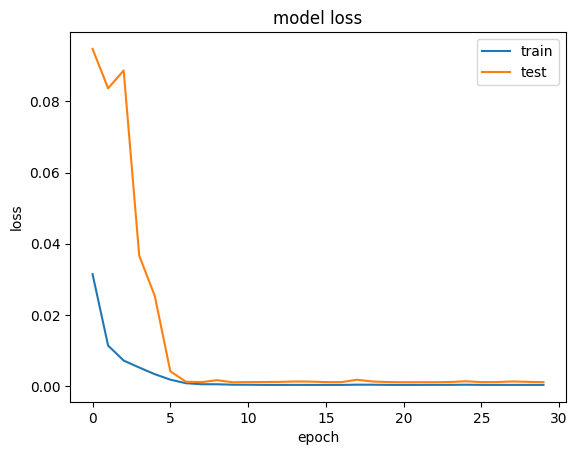

In [22]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [23]:
predictions_train = model.predict(X_train)

inverse_predictions_train = inverse_transform(scaler, predictions_train)
y_train_original = scaler.inverse_transform(np.concatenate((X_train[:, -1, :], y_train.reshape(-1, 1)), axis=1))[:, -1]

compare_model_train = pd.DataFrame({'Predicted': inverse_predictions_train, 'Actual': y_train_original})
compare_model_train.head()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


,Predicted,Actual
0,23852.977921,23475.466797
1,23877.142399,22362.679688
2,23476.732888,22353.349609
3,22671.774893,22435.513672
4,22790.808481,22429.757813


In [24]:
predictions_test = model.predict(X_test)

inverse_predictions_test = inverse_transform(scaler, predictions_test)
y_test_original = scaler.inverse_transform(np.concatenate((X_test[:, -1, :], y_test.reshape(-1, 1)), axis=1))[:, -1]

compare_model_test = pd.DataFrame({'Predicted': inverse_predictions_test, 'Actual': y_test_original})
compare_model_test.tail()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,Predicted,Actual
68,52162.839114,51733.238281
69,52849.463149,54522.402344
70,54491.865704,57085.371094
71,58542.082107,62504.789063
72,64061.162774,61198.382813


# METRIKS EVALUASI

In [25]:
mse_model_train = mean_squared_error(y_train_original, inverse_predictions_train)
mse_model_test = mean_squared_error(y_test_original, inverse_predictions_test)
rmse_model_train = np.sqrt(mse_model_train)
rmse_model_test = np.sqrt(mse_model_test)
print("Root Mean Squared Error (RMSE) Train Set:", rmse_model_train)
print("Root Mean Squared Error (RMSE) Test Set:", rmse_model_test)
print("======================================================")

r2_xgb_train = r2_score(y_train, predictions_train)
r2_xgb_test = r2_score(y_test, predictions_test)
print("\nR-squared Train Set:", r2_xgb_train)
print("R-squared Test Set:", r2_xgb_test)
print("======================================================")

Root Mean Squared Error (RMSE) Train Set: 741.2103427042307
Root Mean Squared Error (RMSE) Test Set: 1400.8903957191208

R-squared Train Set: 0.975050188600615
R-squared Test Set: 0.9166958051313834


# VISUALISASI

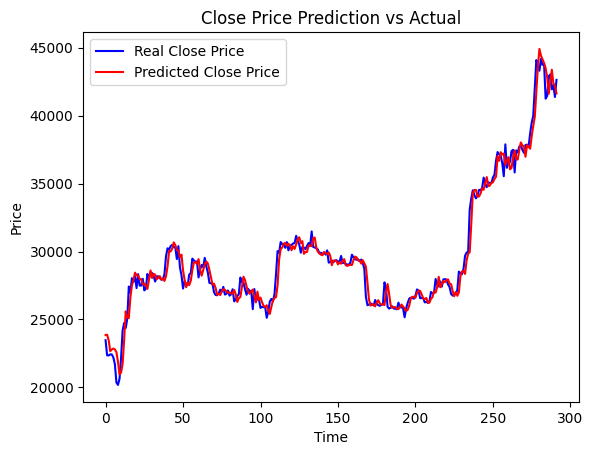

In [26]:
# lineplot train
lineplot(y_train_original, inverse_predictions_train)


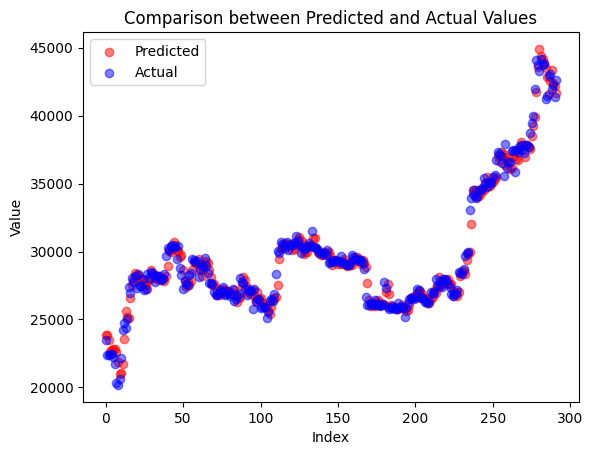

In [27]:
# scatterplot train
scatterplot(y_train_original, inverse_predictions_train)


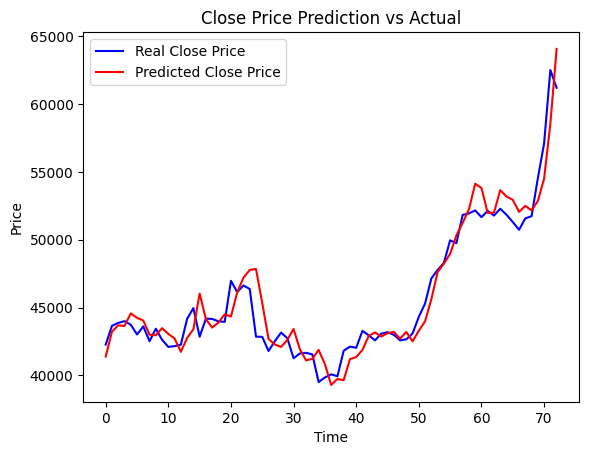

In [28]:
# lineplot test
lineplot(y_test_original, inverse_predictions_test)

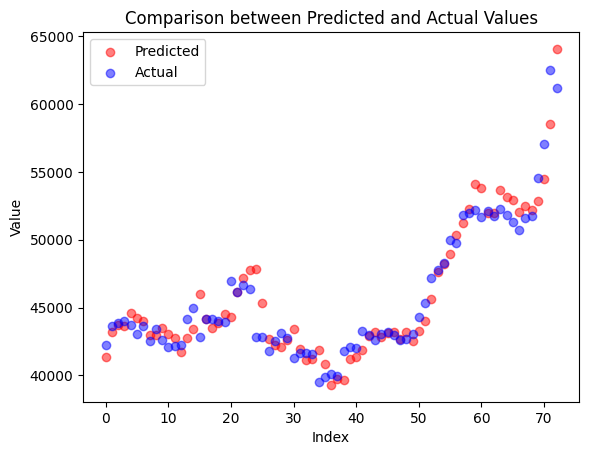

In [29]:
# scatterplot test
scatterplot(y_test_original, inverse_predictions_test)

# SHAP

In [ ]:
features = ["Open", "High", "Low", "Volume", "Sentimen", "Index"]

explainer = shap.DeepExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features)

# TEST DENGAN DATA BARU

In [30]:
dt = pd.read_excel('Data/all_data_validation.xlsx')
dt.head()

,Date,Open,High,Low,Adj_Close,Volume,Sentimen,Index,Close
0,2024-03-01,61168.062500,63155.101563,60802.527344,62440.632813,40186368423,positif,59,62440.632813
1,2024-03-02,62431.652344,62458.699219,61657.289063,62029.847656,23888473685,positif,46,62029.847656
2,2024-03-03,62031.578125,63230.210938,61435.023438,63167.371094,26253811450,positif,44,63167.371094
3,2024-03-04,63137.003906,68537.031250,62386.519531,68330.414063,70670471105,positif,81,68330.414063
4,2024-03-05,68341.054688,69170.625000,59323.910156,63801.199219,102802940877,positif,100,63801.199219


In [31]:
dt = dt.drop(columns=["Date", 'Adj_Close'])

In [32]:
sentimen_mapping = {'positif': 1, 'negatif': -1, 'netral': 0}
dt['Sentimen'] = dt['Sentimen'].map(sentimen_mapping)

In [33]:
dt.describe()

,Open,High,Low,Volume,Sentimen,Index,Close
count,31.000000,31.000000,31.000000,3.100000e+01,31.000000,31.000000,31.000000
mean,67372.752394,69272.725933,65532.276714,4.665864e+10,0.548387,56.419355,67702.439264
std,3292.243235,2911.385403,3273.325051,2.025387e+10,0.809885,15.751771,3157.882425
min,61168.062500,62458.699219,59323.910156,1.713024e+10,-1.000000,35.000000,61912.773438
25%,64693.548828,68068.425782,62617.595703,3.079077e+10,0.500000,45.500000,65403.253907
50%,68299.257813,69170.625000,65655.531250,4.448035e+10,1.000000,52.000000,68330.414063
75%,69770.613282,71456.761719,68472.476563,6.107452e+10,1.000000,63.000000,69925.820312
max,73079.375000,73750.070313,71334.093750,1.028029e+11,1.000000,100.000000,73083.500000


In [34]:
X_ = dt.drop(columns=['Close'])
y_ = dt['Close']

In [35]:
X, y, scalers = scale_data(dt)

In [36]:
predictions = model.predict(X) 

inverse_predictions_new = inverse_transform(scalers, predictions)
y_test_original_new = inverse_transform(scalers, y)

compare_model_test = pd.DataFrame({'Predicted': inverse_predictions_new.flatten(), 'Actual': y_test_original_new.flatten()})
compare_model_test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


,Predicted,Actual
0,62723.599228,62029.847656
1,63073.816173,63167.371094
2,63140.071555,68330.414063
3,65669.789574,63801.199219
4,66620.045820,66106.804688
5,65711.064868,66925.484375
6,67419.430952,68300.093750
7,68695.671528,68498.882813
8,69024.209972,69019.789063
9,69478.525169,72123.906250


In [37]:
mse_model_newdata = mean_squared_error(y_test_original_new, inverse_predictions_new)
rmse_model_newdata = np.sqrt(mse_model_newdata)
print("Root Mean Squared Error (RMSE) Test Set:", rmse_model_newdata)
print("======================================================")

# Menghitung R-square
r2_xgb_test = r2_score(y_test_original_new, inverse_predictions_new)
print("R-squared Test Set:", r2_xgb_test)
print("======================================================")

Root Mean Squared Error (RMSE) Test Set: 2448.386857635819
R-squared Test Set: 0.335305138863105


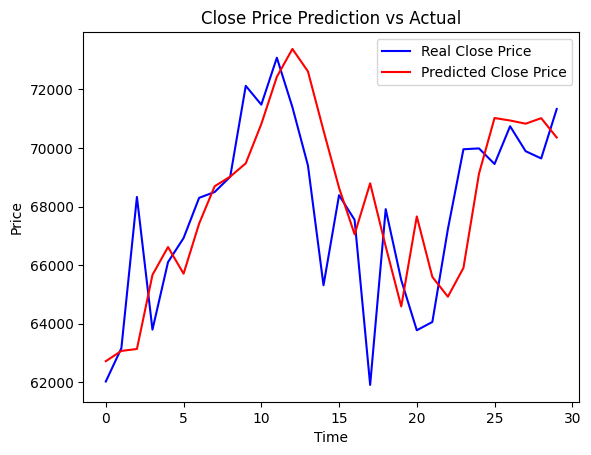

In [38]:
lineplot(y_test_original_new, inverse_predictions_new)

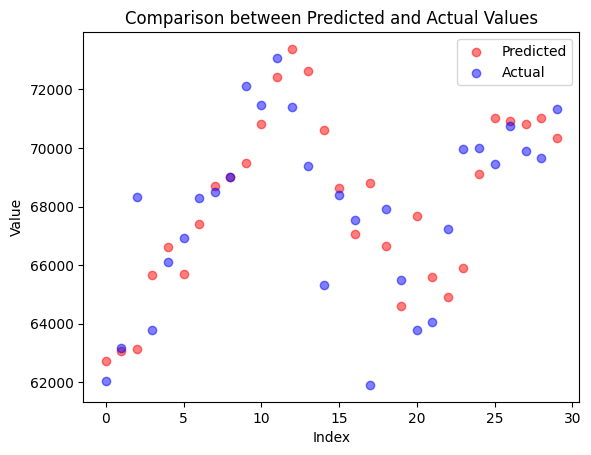

In [39]:
scatterplot(y_test_original_new, inverse_predictions_new)